
<div style="height:40px"><h2 style="align-content:center;padding:10px;color:white;background-color:#A4644E;float:left;margin-top:0px">Máster en Big Data y Data Science</h2>
<h2  style="align-content:center;padding:10px;color:white;background-color:#E0A030;float:left;margin-top:0px;">Fundamentos de análisis de datos</h2></div>


## Árboles de decisión
En este ejercicio vamos a ver el funcionamiento básico de los árboles de decisión. Haremos algunos ejemplos en problemas en 2D para su visualización y otros problemas para ver sus capacidades y debilidades. Al final del ejercicio serás capaz de:
<ul>
<li>Describir el mecanismo utilizado por los árboles de decisión para construir modelos reduciendo la impureza de los datos</li>
<li>Reconocer el aspecto de las fronteras de decisión de los árboles</li>
<li>Comprobar cómo varía la estructura del árbol modificando el número de ejemplo mínimos que cae en cada hoja</li>
<li>Medir tiempo de entrenamiento de los árboles con respecto al número de ejemplos</li>
</ul>

In [1]:
# Hacemos los imports necesarios
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import numpy.matlib as matl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

### 1.- Cómo encontrar la mejor división en los datos: Crieterio de Gini
Vamos a implamentar una serie de funciones para encontrar la mejor división de los datos usando el criterio de Gini. Para ello vamos a implementar rtes funciones.

##### Función de impureza
Vamos a implementar una función para la impureza de Gini que se usa en los árboles CART:

$$
i(t) = \sum_{i=1}^{M} f_{i} (1-f_{i})
$$

La función recibe una lista con el histograma con el número de ejemplos para cada clase. Debe devolver su impureza.

In [2]:
# impurityGini: Calcula la impureza de Gini
#    Entrada: 
#      -fs: lista/vector con el histograma con el número de ejemplos
#           para cada clase.
#    Salida:
#      -i(t): Impureza
def impurityGini(fs):
    fs_norm = fs/float(sum(fs))
    return sum(fs_norm*(1-fs_norm))

#  Implementación con bucles seria
#  fs_norm = fs/float(sum(fs))
#  s = 0
#  for fi in fs_norm:
#      s + = fi*(1-fi)
#  return s

##### Tests función de impureza

In [3]:
tolerancia = 0.000000001
# Usando número de ejemplos. Debe devolver 0.44444444
num_ejemplos = np.array([4.,8.])
assert(abs(impurityGini(num_ejemplos)-4./9)<tolerancia)

# Usando clases puras. Debe devolver 0
num_ejemplos = np.array([12.,0.])
assert(abs(impurityGini(num_ejemplos))<tolerancia)

# Usando clases equilibradas. Debe devolver 0.5
num_ejemplos = np.array([6.,6.])
assert(abs(impurityGini(num_ejemplos)-0.5)<tolerancia)

# Usando 4 clases y equilibradas. Debe devolver 0.75
num_ejemplos = np.array([4.,4.,4.,4.])
assert(abs(impurityGini(num_ejemplos)-0.75)<tolerancia)

# Usando 4 clases deequilibradas. Debe devolver 0.5546875
num_ejemplos = np.array([8.,0.,7.,1.])
assert(abs(impurityGini(num_ejemplos)-0.5546875)<tolerancia)

print("Todo OK")

Todo OK


##### Grafica de función de impureza

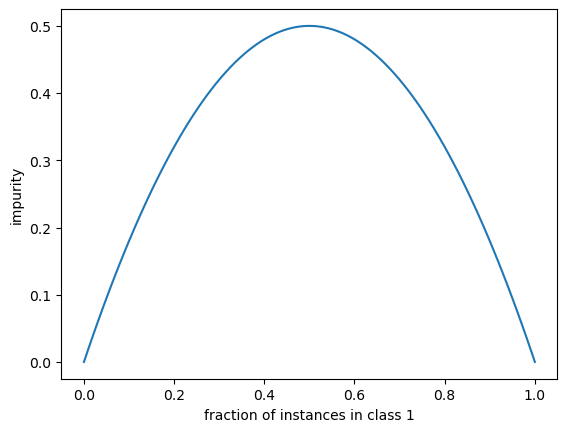

In [4]:
# Debe mostrar una gráfica con una parábola invertida
fracciones = np.linspace(0,1,100)
impurities = list(map(impurityGini,np.array(list(zip(fracciones,1-fracciones)))))
plt.ylabel("impurity")
plt.xlabel("fraction of instances in class 1")
_ = plt.plot(fracciones, impurities)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo la gráfica responde a las siguientes preguntas:
<ul>
<li>(1) ¿En qué punto se alcanza la mayor impureza de los datos? ¿A qué distribución de clases correnpondería?</li>
<li>(2) ¿En qué punto se alcanza la menor impureza de los datos? ¿A qué distribución de clases correnpondería?</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(1): Responde aquí </li>
<li>(1): 

- La impureza más alta se alcanza en una fracción de instancias en la clase 1 de 0.5.

- Esto corresponde a una distribución de clases donde hay un número igual de instancias en ambas clases (50% en la clase 1 y 50% en la clase 2). </li>

<li>(2): Responde aquí </li>
<li>(2): 

- La impureza más baja se alcanza con una fracción de instancias en la clase 1 de 0 y 1.

- Esto corresponde a una distribución de clases donde todas las instancias pertenecen a la clase 1 o la clase 2. En otras palabras, no hay instancias donde los puntos de datos caen en ambas clases. </li>


La impureza es más alta cuando las clases están equilibradas (alrededor de 0.5) y más baja cuando hay una clase mayoritaria clara.

</ul>
</div>

##### Función para calcular la reducción de impureza
Vamos a implementar una función de variación de impureza para un nodo $t$ y división $s$ utilizado en los árboles CART:

$$
\Delta i(t, s) = i(t) - p_L \times i(t_L) - p_R \times i(t_R)
$$

La función recibe una lista con los histogramas o fracción de ejemplos para cada clase para el nodo derecho e izquierdo y te devuelve la variación de impureza.

In [5]:
# impurityReduction: Calcula la reducción de impureza de Gini a partir
#      de las distribuciones de ejemplos en el nodo derecho e izquierdo.
#      para saber la distribución antes de la división hay que sumar
#      fs_left y fs_right
#    Entrada: 
#      -fs_left:  lista/vector con el histograma de ejemplos
#                 para cada clase que van al nodo izq tras la división.
#      -fs_right: lista/vector con el histograma o fraccion de ejemplos
#                 para cada clase que van al nodo dcho tras la división.
#    Salida:
#      -Delta i(t): Variación de la impureza
def impurityReduction(fs_left, fs_right):
    it = impurityGini(fs_left+fs_right)
    iL = impurityGini(fs_left) 
    iR = impurityGini(fs_right)
    sL = sum(fs_left)
    sR = sum(fs_right)
    return it - iL*sL/(sL+sR) - iR*sR/(sL+sR)


##### Tests función impurityReduction

In [6]:
tolerancia = 0.000000001

#Debe devolver 0.5
lf = np.array([4.,0.])
rg = np.array([0.,4.])
assert(abs(impurityReduction(lf,rg)-0.5)<tolerancia)

#Debe devolver 0.11111111111
lf = np.array([4.,0.])
rg = np.array([4.,4.])
assert(abs(impurityReduction(lf,rg)-0.1111111111111)<tolerancia)

#Debe devolver 0
lf = np.array([4.,4.])
rg = np.array([4.,4.])
assert(abs(impurityReduction(lf,rg))<tolerancia)

print("Todas OK")

Todas OK


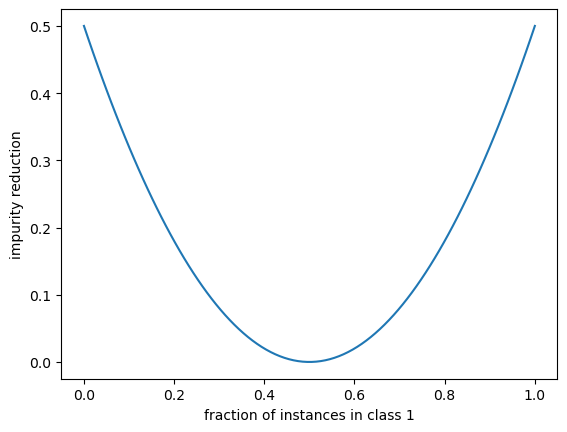

In [7]:
# Debe mostrar una gráfica con una parábola
fracciones = np.linspace(0,1,100)
impurities = list(map(lambda x: impurityReduction(np.array([x,1-x]),np.array([1-x,x])),fracciones))
plt.ylabel("impurity reduction")
plt.xlabel("fraction of instances in class 1")
_ = plt.plot(fracciones, impurities)


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo los valores de las pruebas responde a las siguientes preguntas:
<ul>
<li>(3) ¿Qué división se hace cuando se reduce 0'5 la impureza (caso 1 arriba)? ¿Qué distribución de clases tienen antes de la división?¿Y después?</li>
<li>(4) ¿Qué división se hace cuando no se reduce la impureza (caso 3 arriba)? ¿Qué distribución de clases tienen antes de la división?¿Y después?</li>
</ul>
</div>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:

- Los árboles de decisión utilizan la reducción de la impureza para elegir la mejor manera de dividir los datos en cada nodo.

- Una mayor ganancia de información indica una mejor división que separa los datos en nodos secundarios más puros.

<ul>
<li>(3): Aquí tu respuesta</li>
<li>(3):  

- Caso 1: Reducción de Impureza de 0,5: Aquí, la reducción de impureza es la más alta (0.5), lo que suele ocurrir cuando los datos se dividen perfectamente a la mitad según la característica elegida.

- Antes de la División: Los datos tienen una distribución de clases equilibrada, lo que significa que hay aproximadamente un número igual de instancias en cada clase (el 50% en la clase 1 y el 50% en la clase 2).

- Después de la División: La división crea dos nodos secundarios, cada uno de los cuales contiene aproximadamente la mitad de los puntos de datos de los datos originales. Idealmente, estos nodos secundarios tendrán una clase dominante, lo que resultará en distribuciones más puras en comparación con el nodo padre. Después de la división, los nodos secundarios idealmente contendrán todos los puntos de datos de una clase cada uno, dando como resultado nodos secundarios puros (impureza 0).

</li>
<li>(4): Aquí tu respuesta</li>
<li>(4): 

- Caso 3: Sin Reducción de Impureza: Este escenario indica que la característica elegida no separa efectivamente los datos en función de la variable objetivo.

- Antes de la División: Los datos pueden tener cualquier distribución de clases, pero tienen una impureza inherente donde no exista una separación clara entre clases basada en la característica elegida.

- Después de la División: La división esencialmente replica la distribución de datos original en los nodos secundarios. Dado que la característica no ayuda a distinguir las clases, la impureza permanece sin cambios.

</li>
</ul>
</div>

##### Función para calcular la mejor partición a partir de un conjunto de datos
Esta función debe recorrer todos los atributos (columnas) de los datos y calcular todas las posibles divisiones recorriendo valores de los ejemplos ordenados (filas).

La función recibe una matriz X con los datos y un vector y con las clases para cada dato donde la primera clase es la 0, la segunda la 1, etc. Debe devolver el atributo donde se ha encontrado la mejor división y el umbral de corte.

In [8]:
# findBestSplit: Busca la mejor partición de los datos usando el criterio de Gini
#
#    Entrada: 
#     - X: Matriz de ejemplos con atributos en columnas y datos en filas
#      -y: Vector con las clases de cada ejemplo. Debe ser de la misma 
#          longitud que el numero de filas de X
#    Salida:
#      -atributo de la división 
#      -valor para el corte
def findBestSplit(X, y):
    assert(X.shape[0]==len(y))
    irmax = 0
    for ia in range(X.shape[1]):           # Recorremos atributos
        idx         = np.argsort(X[:,ia])      # Ordenamos los datos por el atributo de índice ia
        attr_sorted = X[idx,ia]
        y_sorted    = y[idx]
        hist_left   = np.array([0.0, 0.0])     # Inic num. ejemplos en hoja izq -> ninguno
        hist_right  = np.bincount(y)           # Inic. num. ejemplos en hoja dcha -> todos
        for isplit in range(X.shape[0]-1): # Recorremos las posibles divisiones
            hist_left[y_sorted[isplit]]  += 1.0    # Actualizamos histogramas de num. ejemplos añadiendo a hoja izq
            hist_right[y_sorted[isplit]] -= 1.0    #                                        y eliminando de la dcha
            if attr_sorted[isplit] != attr_sorted[isplit+1]: # Si este dato y el siguiente son distintos se calcula
                ir = impurityReduction(hist_left, hist_right)    # la reducción de impureza
                if ir > irmax:                                   # Si mejoramos guardamos el atrib. y umbral corte
                    irmax = ir
                    iatt_best = ia
                    threshold_best = attr_sorted[isplit] + (attr_sorted[isplit+1] - attr_sorted[isplit])/2.
            
    return iatt_best, threshold_best


In [9]:
# Ejemplo del ppt
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Debe devolver (1, 3.5)
findBestSplit(X,clase)

(1, 3.5)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Viendo el funcionamiento de la función:
<ul>
<li> (5) Describe cómo es el prodecimiento para buscar la mejor división en los árboles de decisión</li>
</ul>
</div>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(5): Aquí tu respuesta</li>
<li>(5): Buscar la mejor división en los árboles de decisión:

- Calcular la Medida de Impureza: Calculamos una medida de impureza (impureza de Gini) para cada división potencial basada en los valores de la variable objetivo en los subconjuntos resultantes.

- Calcular la Ganancia de Información (la reducción de impureza): Para cada división, calculamos la ganancia de información, que es la reducción de la impureza lograda al dividir los datos.

- Seleccionar la División con Máxima Ganancia de Información: Elegimos la división que maximice la ganancia de información. Esta división separa efectivamente los datos en subconjuntos más homogéneos con respecto a la variable objetivo.

- Repetir para Cada Atributo: Repetimos el proceso para todos los atributos disponibles, seleccionando la división con la mayor ganancia de información entre los atributos.

Determinar la mejor división en un árbol de decisión implica evaluar las divisiones potenciales en función de su capacidad para disminuir la impureza o aumentar la homogeneidad en los subconjuntos resultantes. Al seleccionar divisiones que maximicen la ganancia de información, los árboles de decisión pueden particionar los datos de manera efectiva y construir modelos predictivos que se generalicen bien a datos no vistos.

**También en los códigos anteriores:**

- La función recorre en bucle cada característica (columna) en la matriz de datos X.

Los puntos de datos se ordenan según los valores de esa característica específica. Esto crea una lista ordenada donde los puntos de datos con valores de características similares se agrupan.

hist_left: Rastrea el número de puntos de datos pertenecientes a cada clase (clase 0 y 1) que se asignarían al nodo hijo izquierdo para una división potencial.


hist_right: Rastrea el número de puntos de datos en cada clase que se asignarían al nodo hijo derecho para una división potencial.

La función itera a través de todos los umbrales posibles (puntos de división) dentro de los datos ordenados. Un umbral es el valor entre dos puntos de datos consecutivos en la lista de características ordenadas.

- La función verifica si el umbral actual es diferente del valor del siguiente punto de datos. Esto asegura que solo calculemos la reducción de impureza para umbrales únicos.

Si se trata de un umbral único, se llama a la función impurityReduction con los hist_left, hist_right. Esta función calcula la reducción de impureza lograda al dividir los datos en función de la característica y el umbral actuales.

- La reducción de impureza calculada se compara con la reducción de impureza máxima actual (irmax).

Si la nueva reducción es mayor, significa una mejor separación entre clases. En ese caso, la función se actualiza:

irmax: Almacena la nueva reducción máxima de impureza.

iatt_best: Almacena el índice de la característica (atributo) que condujo a la mejor división hasta ahora.

threshold_best: Calcula el valor promedio entre los valores de característica del punto de datos actual y el siguiente, representando el punto medio del rango de división potencial.

- Después de iterar a través de todas las características y umbrales, la función devuelve los índices del mejor atributo (iatt_best) y el mejor umbral correspondiente (threshold_best). Estos valores representan la característica y el punto de división que maximizan la reducción de impureza, lo que conduce a una separación más informativa de los puntos de datos en el árbol de decisión.

</li>
</ul>
</div>

### 2.- Conjuntos en 2D para el anáilisis visual de las fronteras de decisión y cómo cambian con algunos parámetros

##### Funciones auxiliares
Antes definiremos algunas funciones (autores Luis Lago y Manuel Sanchez Montañes) que usaremos a lo largo de la práctica. La primera, *createDataSet*, es para crear los problemas, siempre con dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [10]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, c, xbnd, ybnd
    else:
        return x, y, c

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [11]:
def plotModel(x,y,clase,clf,title):
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(1, 1, 1)
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter([x[clase==0]], [y[clase==0]], c='#FF0000')
        plt.scatter([x[clase==1]], [y[clase==1]], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [12]:
def plotData(x,y,c,style0,style1,title):
    plt.plot(x[c==0],y[c==0],style0)
    plt.plot(x[c==1],y[c==1],style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

#### Visualizar el árbol
Se entrena un árbol usando los datos del ppt y visualizamos su estructura y la frontera de decisión

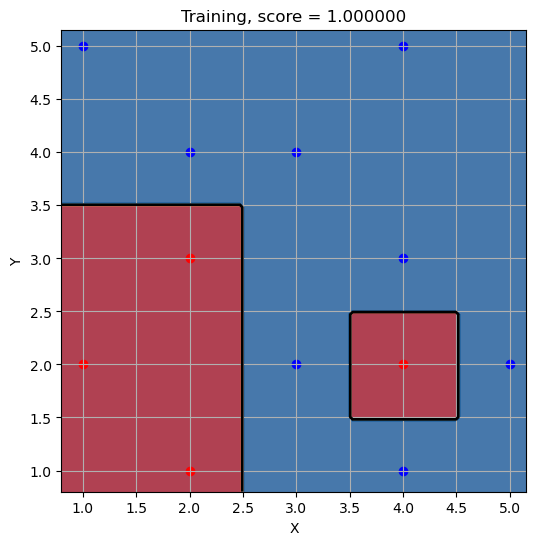

In [13]:

# Datos
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=1, max_depth=None)   # Rellenar

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))



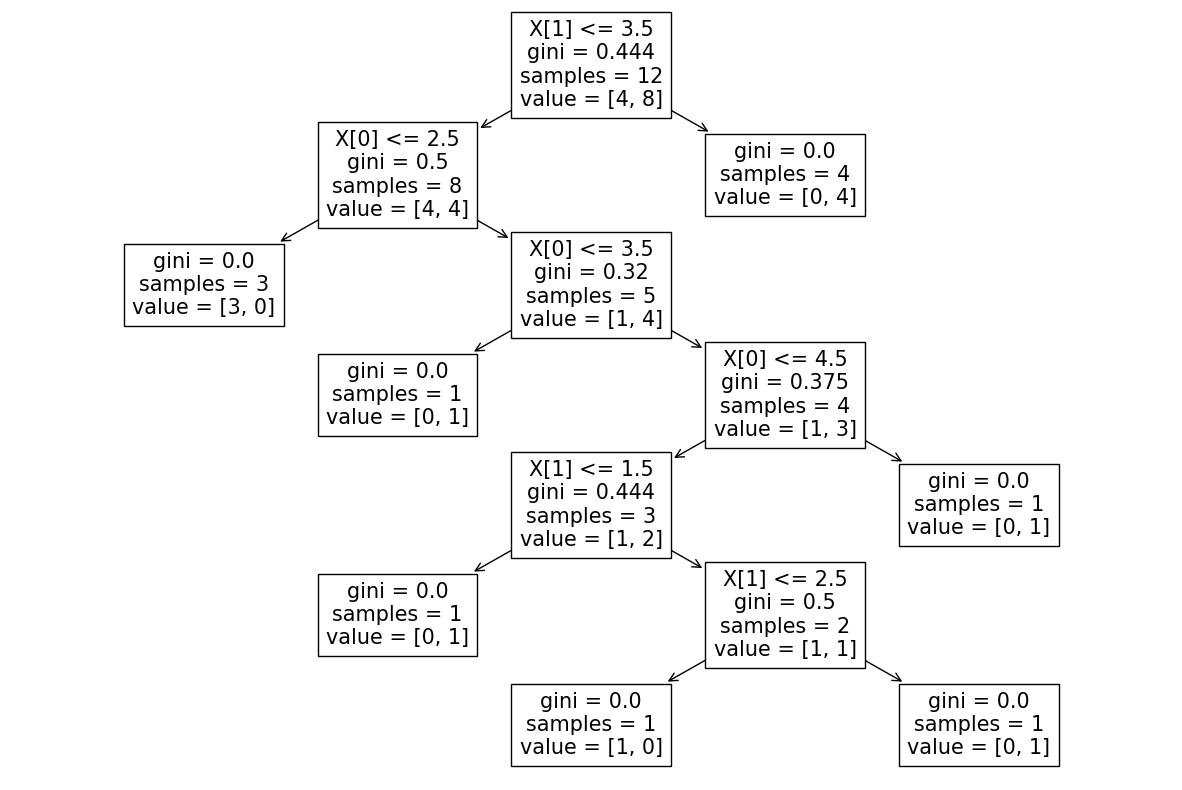

In [14]:
plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf)

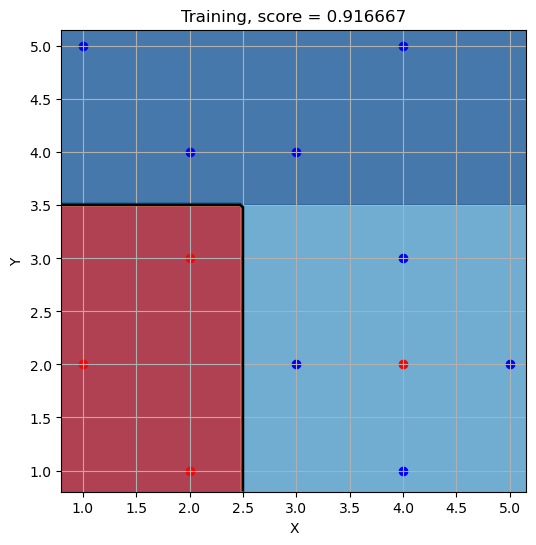

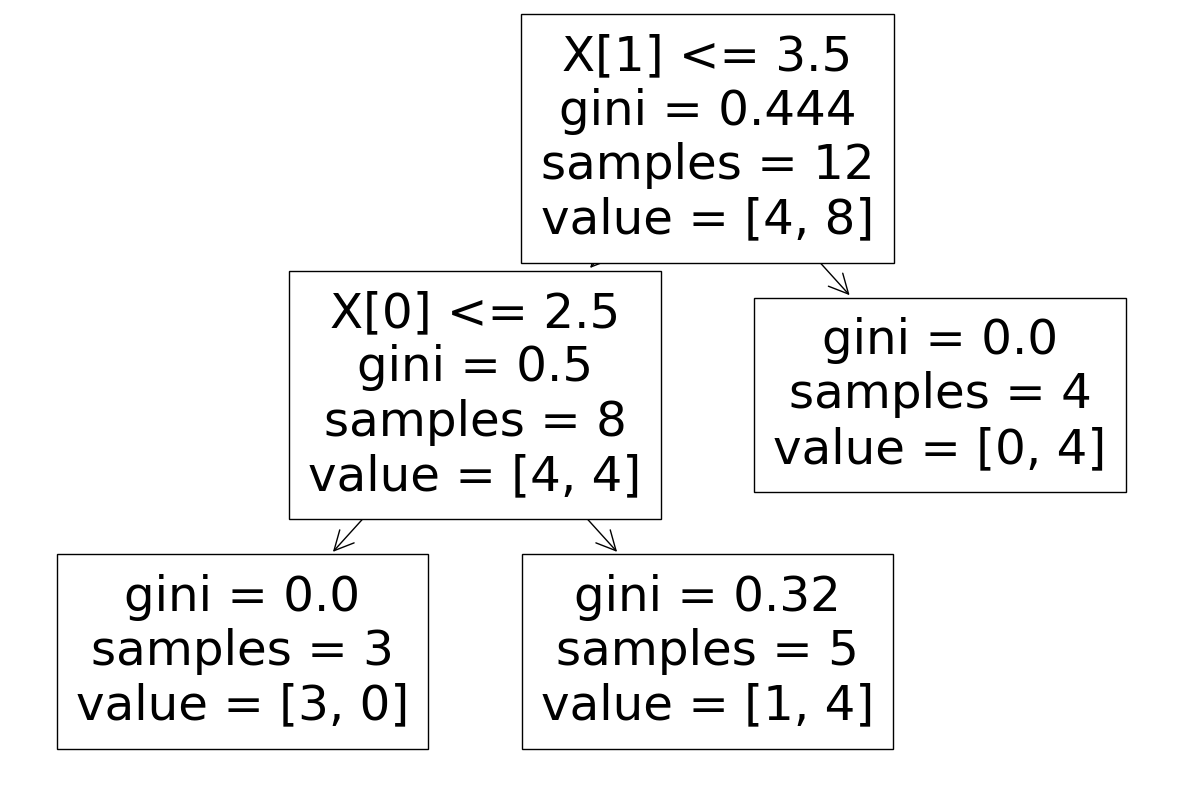

In [15]:
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=2, max_depth=None)   # Establecemos con min_samples_leaf=2

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))

plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf)

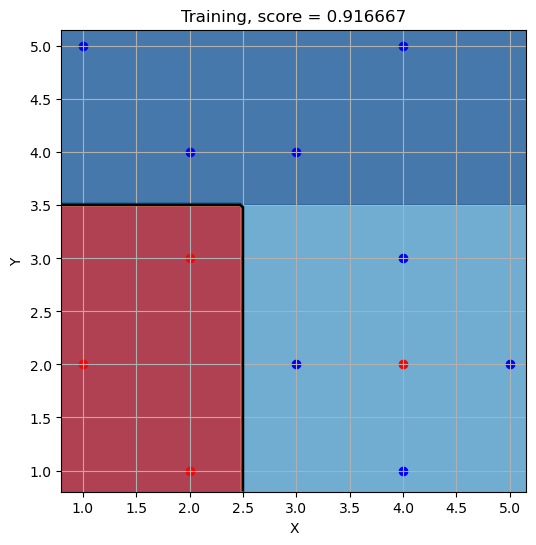

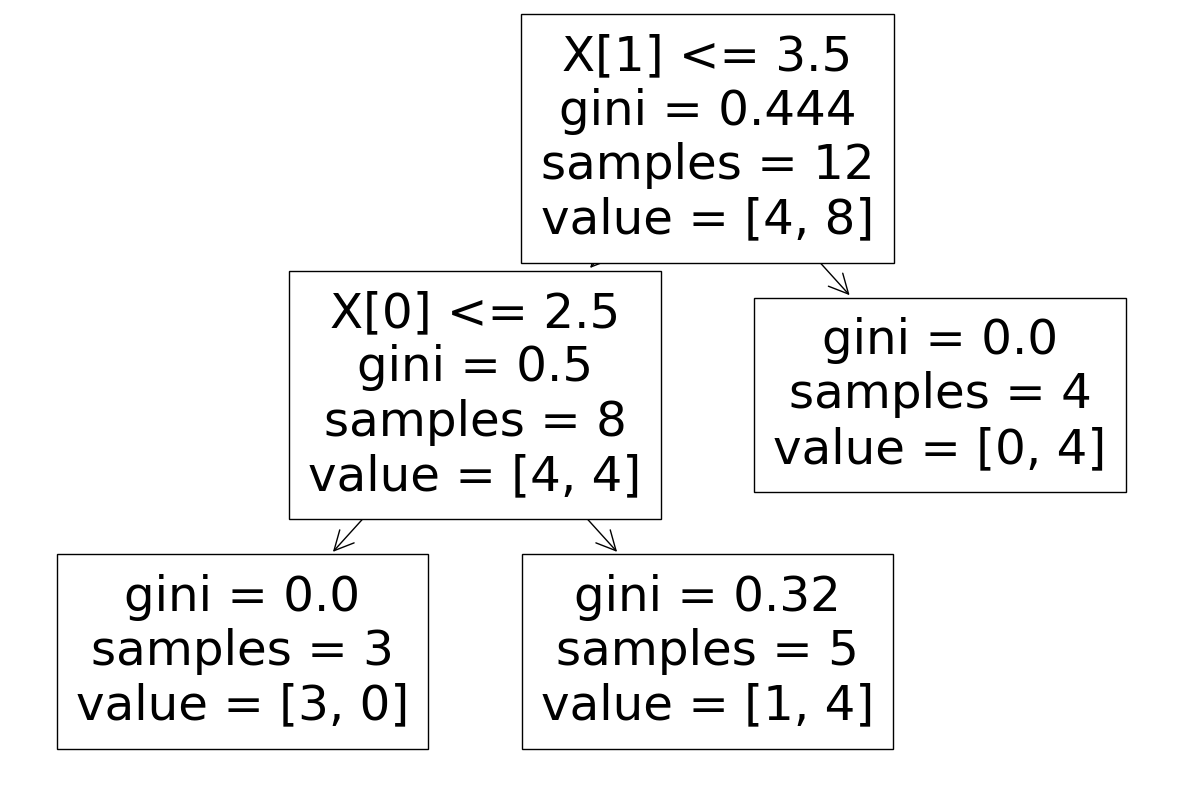

In [16]:
X = np.array([[1, 2],[1, 5],[2, 1],[2, 3],
              [2, 4],[3, 2],[3, 4],[4, 1],
              [4, 2],[4, 3],[4, 5],[5, 2]])
clase = np.array([0,1,0,0,1,1,1,1,0,1,1,1])

# Declaración del clasificador:
clf = tree.DecisionTreeClassifier(criterion="gini", min_samples_leaf=1, max_depth=2)   # Establecemos con max_depth=2

# Entrenar el clasificador
clf.fit(X, clase)                                       # Rellenar

# Clasificar datos
score_train = clf.score(X, clase)

# Frontera de decisión:
plt.figure(figsize=(6,6))
plotModel(X[:,0],X[:,1],clase,clf,"Training, score = %f" % (score_train))

plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf)

<div style="background-color:#AAEEAA;padding:20px;border:solid;">
<ul>
<li> (6) Modifica parámetros de construcción del árbol para obtener un árbol más compacto que elimine el cuadrado rojo de abajo a la derecha. Indica qué parámetro has modificado y explica las diferencias que creeís que hay entre los árboles que usan prepoda con max_depth o con min_samples_leaf.</li>
</ul>
</div>
<p></p>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuestas:
<ul>
<li>(6): Aquí tu respuesta</li>
<li>(6): 

**Modificamos min_samples_leaf=2, max_depth=None :** Este parámetro especifica el número mínimo de puntos de datos permitidos en un nodo hoja. Afecta indirectamente la profundidad del árbol al evitar divisiones adicionales si un nodo no tiene suficientes puntos de datos. Cuando observamos el modelo de árbol, no podemos ver ningún punto de datos por debajo de 2 porque detuvimos la división estableciendo min_samples_leaf = 2. Así que podemos eliminar el cuadrado rojo.

**Cuando min_samples_leaf=2:**

- El modelo de gráfico contiene un total de 12 puntos de datos.
- En el proceso de división, primero separa 8 puntos de datos y luego 4 puntos de datos individualmente en 2 grupos.
- En la parte inferior del modelo de gráfico, se dividen nuevamente los 8 puntos de datos en 5 y 3 puntos de datos, respectivamente.
- Por lo tanto, finalmente se divide en solo 3 cuadrados y vemos 3, 4 y 5 puntos de datos en cada cuadrado.
- No vemos puntos de datos debajo de "2" y "2" porque al establecer el parámetro, hemos limitado los puntos de datos y detenido la división.

**Modificamos min_samples_leaf=1, max_depth=2 :** Este parámetro establece la profundidad máxima que puede alcanzar un árbol. Al establecer max_depth en 2, obligamos al árbol a dejar de crecer después del segundo nivel de divisiones. Un max_depth más pequeño conduce a un árbol menos profundo, lo que podría eliminar el cuadrado rojo de la parte inferior derecha.  Al observar el modelo de árbol, podemos ver que se detiene después de la segunda división y no se divide más.

**Cuando max_depth=2:**

- Aquí hemos limitado la profundidad a 2 para que no haya más de 2 divisiones. 
- Una vez que el modelo de árbol se ha dividido 2 veces, podemos ver 3 cuadrados y 3, 4 y 5 puntos de datos en estos cuadrados, con un total de 12 puntos de datos.


**Si examinamos ambos modelos de gráfico, podemos ver que son compatibles con el modelo de árbol de decisión.**

max_depth ofrece un control más directo sobre el tamaño del árbol, limitando la profundidad independientemente de la distribución de datos.

min_samples_leaf permite que el árbol crezca potencialmente más profundo si hay suficientes datos para soportar divisiones adicionales.

max_depth puede ser más rígido y podría pasar por alto posibles mejoras en niveles más profundos del árbol.

min_samples_leaf permite una mayor flexibilidad en la estructura del árbol según la distribución de los datos.

Un valor de max_depth muy pequeño puede conducir a subajuste si los datos tienen relaciones complejas.

Un valor de min_samples_leaf muy pequeño también podría conducir a subajuste al detener las divisiones prematuramente.

</li>
</ul>
</div>

##### Ejemplo con funciones más complejas



<div style="background-color:#AAEEAA;padding:20px;border:solid;">Ejecuta las dos celdas siguientes utilizando 0 ruido en los datos y un ruido de 0.3. Después prueba con min_samples_leaf 1 y 10 para cada uno de los niveles de ruido y rellena el acierto en test y train en la siguiente tabla:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(7) Respuestas:
 <table>
  <tr>
    <td>Acierto train/test</td>
    <td>min_samples_leaf=1</td>
    <td>min_samples_leaf=10</td>
  </tr>
  <tr>
    <td>noise=0</td>
    <td> Score train = 1.000000 / Score test = 0.939667 </td>
    <td> Score train = 0.933333 / Score test = 0.898333 </td>
  </tr>
  <tr>
    <td>noise=0.3</td>
    <td> Score train = 1.000000 / Score test = 0.838000 </td>
    <td> Score train = 0.896667 / Score test = 0.868333 </td>
  </tr>
</table> 
</div>

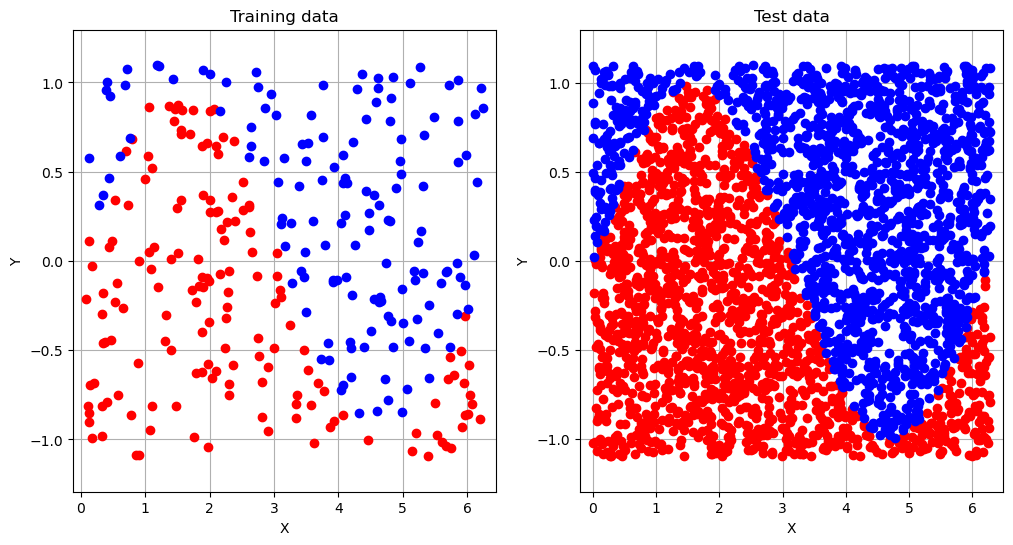

In [17]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0                             # <========= Modifica este valor 0 ó 0.3
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)

# Plots:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotData(x,y,clase,'ro','bo',"Training data")
plt.subplot(122)
plotData(xtest,ytest,clasetest,'ro','bo',"Test data")

Score train = 1.000000
Score test = 0.939667


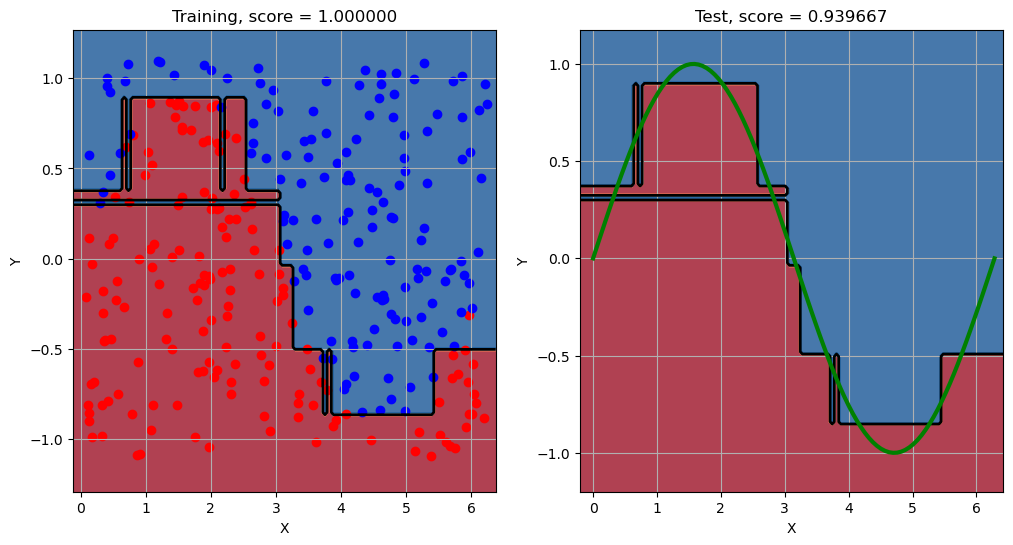

In [18]:
# Construcción del clasificador:
clf = tree.DecisionTreeClassifier(min_samples_leaf=1)     # <========= Modifica este valor 1 ó 10
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 0.933333
Score test = 0.898333


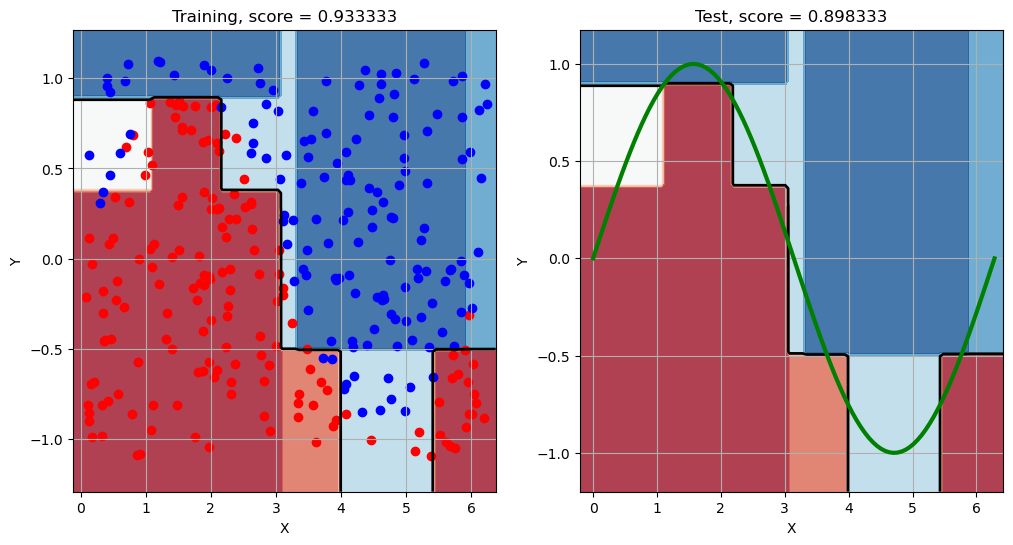

In [19]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0                             # <========= Modifica este valor 0 ó 0.3
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)

# Construcción del clasificador:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)     # <========= Modifica este valor 1 ó 10
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 1.000000
Score test = 0.838000


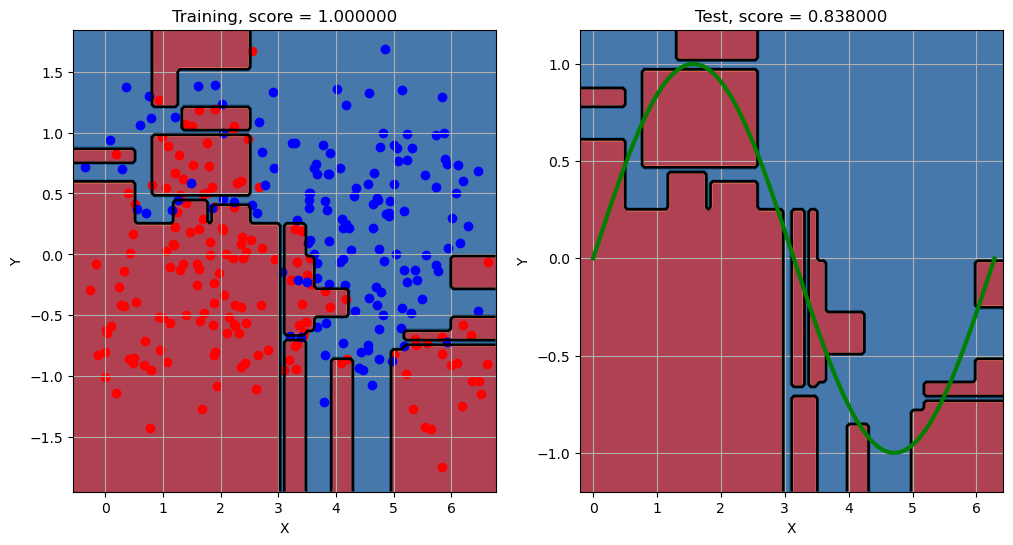

In [20]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                             # <========= Modifica este valor 0 ó 0.3
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)

# Construcción del clasificador:
clf = tree.DecisionTreeClassifier(min_samples_leaf=1)     # <========= Modifica este valor 1 ó 10
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

Score train = 0.896667
Score test = 0.868333


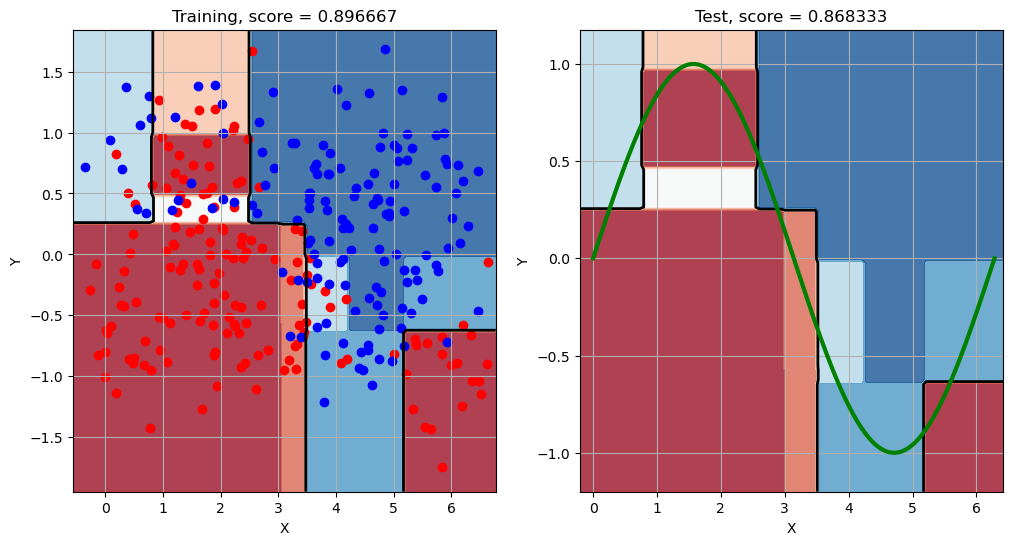

In [21]:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3                             # <========= Modifica este valor 0 ó 0.3
x, y, clase, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
xtest, ytest, clasetest = createDataSet(n*10, model, ymargin, noise)

# Construcción del clasificador:
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)     # <========= Modifica este valor 1 ó 10
clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  

# Calculo del acierto en los conjuntos de entrenamiento y test:
score_train = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
print("Score train = %f" % (score_train))
score_test = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
print("Score test = %f" % (score_test))

# Gráficas:
plt.figure(figsize=(12,6))
plt.subplot(121)
plotModel(x,y,clase,clf,"Training, score = %f" % (score_train))
plt.subplot(122)
plotModel(xbnd,ybnd,None,clf,"Test, score = %f" % (score_test))

A continuación vamos a realizar un bucle para calcular el acierto del árbol en train y test con respecto al parámetro min_samples_leaf usando ruido (noise=0.3). Entrena árboles usando min_samples_leaf de 1 a 30. Muestra los datos en forma de gráfica usando matlibplot


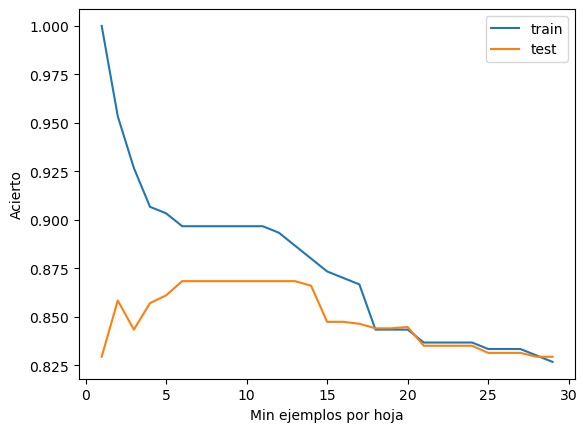

In [126]:
mins_samples = range(1,30)
scores_tr = np.array([0.]*len(mins_samples))
scores_ts = np.array([0.]*len(mins_samples))
i=0
for m in mins_samples:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=m)
    clf.fit(np.concatenate((x, y), axis = 1), np.ravel(clase))  
    # Calculo del acierto en los conjuntos de entrenamiento y test:
    scores_tr[i] = clf.score(np.concatenate((x, y), axis = 1), np.ravel(clase))
    scores_ts[i] = clf.score(np.concatenate((xtest, ytest), axis = 1), np.ravel(clasetest))
    i = i + 1

plt.plot(mins_samples, scores_tr, label='train')
plt.plot(mins_samples, scores_ts, label='test')
plt.xlabel("Min ejemplos por hoja")
plt.ylabel("Acierto")
_ = plt.legend()

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica (si la has hecho) describe qué valores de min_leaf os dan mejores resultados dependiendo del ruido introducido en los datos y da una justificación a los resultados <br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(8) Respuesta: 

Un nivel de ruido de 0.3 no oculta completamente el patrón en los datos. El modelo puede aprender relaciones entre características y la variable objetivo.

Establecer min_samples_leaf en 10 provee al árbol a tener al menos 10 puntos de datos en cada nodo hoja. Esto ayuda a evitar que el árbol se vuelva demasiado complejo y se centre en pequeñas variaciones ruidosas en los datos.

- Un árbol menos profundo con menos divisiones es menos probable que se sobreajuste a los patrones de ruido específicos en los datos de entrenamiento.
- El árbol aún puede aprender límites de decisión con algunas etiquetas ruidosas.

**Con min_samples_leaf alto:**
- El árbol podría volverse demasiado poco profundo y no capturar detalles en los límites de decisión.
- Tendremos menor precisión tanto en datos de entrenamiento como de prueba.


Un nivel de ruido moderado y min_samples_leaf = 10 pueden ayudar a que el modelo aprenda relaciones significativas en los datos de forma robusta al ruido.

Un valor de min_samples_leaf demasiado alto puede llevar a un subajuste y una menor precisión.


</div>

### 3.- Tiempos de entrenamiento y test de los árboles de decisión
Vamos a medir tiempos de entrenamiento y clasificación de árboles de decisión y a compararlos con los tiempos de las SVMs. Probaremos a entrenar los modelos con 300 datos y con 600


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skpp
import timeit
from sklearn.svm import SVC

n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con %d ejemplos: %f s." % (len(indices_train),(toc - tic)/n_executions))

n_executions = 1000

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 1000000.
print("Tiempo de clasificar %g ejemplos: %f s." % (factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 6.909231 s.
Tiempo de clasificar 1e+06 ejemplos: 2.578594 s.


In [23]:
n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
#clf = tree.DecisionTreeClassifier()

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con %d ejemplos: %f s." % (len(indices_train),(toc - tic)/n_executions))

n_executions = 1000

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 1000000.
print("Tiempo de clasificar %g ejemplos: %f s." % (factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 19.240841 s.
Tiempo de clasificar 1e+06 ejemplos: 5.018220 s.


In [24]:
n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 300                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
clf = tree.DecisionTreeClassifier()

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con %d ejemplos: %f s." % (len(indices_train),(toc - tic)/n_executions))

n_executions = 1000

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 1000000.
print("Tiempo de clasificar %g ejemplos: %f s." % (factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 300 ejemplos: 0.001284 s.
Tiempo de clasificar 1e+06 ejemplos: 0.178299 s.


In [25]:
n_executions = 1

# Cargamos datos
fP = 'pimaND.csv'
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

# Dividimos train/test
n_train = 600                                      # <================== Modificar 300 o 600
perm = np.random.permutation(dfP.shape[0])
indices_train = perm[0:n_train]
indices_test  = perm[n_train:]

    
#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1) # <================== Modificar DT o SVM
clf = tree.DecisionTreeClassifier()

# Tiempo de entrenamiento
tic = timeit.default_timer()
for ie in range(n_executions):    # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    clf.fit(dfP.values[indices_train,:-1],dfP.values[indices_train,-1])
toc = timeit.default_timer()

print("Tiempo de entrenamiento con %d ejemplos: %f s." % (len(indices_train),(toc - tic)/n_executions))

n_executions = 1000

# Tiempo de clasificacion
tic = timeit.default_timer()
for ie in range(n_executions):   # Puede ser necesario ejecutarlo varias veces para obtener tiempos más estables
    _ = clf.predict(dfP.values[indices_test,:-1])
toc = timeit.default_timer()

factor = 1000000.
print("Tiempo de clasificar %g ejemplos: %f s." % (factor, factor*(toc - tic)/n_executions/len(indices_test)))

Tiempo de entrenamiento con 600 ejemplos: 0.001979 s.
Tiempo de clasificar 1e+06 ejemplos: 0.436929 s.


<div style="background-color:#AAEEAA;padding:20px;border:solid;">Se debe ejecutar la celda de arriba utilizando árboles o SVMs para medir tiempos de entrenamiento y de clasificación. Hazlo usando 300 datos de entrenamiento y 600. A continuación se debe rellenar los tiempos en la siguiente tabla:<br/></div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">(9) Respuestas:
 <table>
  <tr>
    <td>Tiempos (s) train</td>
    <td>Árbol</td>
    <td>SVM</td>
  </tr>
  <tr>
    <td>Entrenamiento con 300 </td>
    <td> 0.001284 </td>
    <td> 6.909231 </td>
  </tr>
  <tr>
    <td>Entrenamiento con 600</td>
    <td> 0.001979 </td>
    <td> 19.240841 </td>
  </tr>
  <tr>
    <td>Clasificación (10^6 ejemplos)</td>
    <td> 0.178299 </td>
    <td> 2.578594 </td>
  </tr>
  <tr>
    <td>Clasificación (10^6 ejemplos)</td>
    <td> 0.436929 </td>
    <td> 5.018220 </td>
  </tr>
</table> 
</div>
<br/>


In [26]:
import timeit
# Compute training and testing time

# Cargamos datos
fP = 'pimaND.csv'     # <========== Se puede variar el conjunto de datos.
dfP = pd.read_csv(fP, sep=',')
lVarsTarg = dfP.columns

#clf = SVC(C=10.0, kernel='linear', degree=1.0, coef0=1.0, gamma=0.1)
clf = tree.DecisionTreeClassifier()

n_steps = 10           # <========== Se puede variar el numero de paso
n_executions = 1

times_tr = np.array([timeit.default_timer()] * n_steps)
sizes    = np.array([0] * n_steps)
times_ts = np.array([timeit.default_timer()] * n_steps)
sizes_ts = np.array([0] * n_steps)

i = 0
perm = np.random.permutation(dfP.shape[0])
for fraction in  np.linspace(0.1, 0.90, num=n_steps):
    n_train = int(len(perm)*(fraction))
    idxTr = perm[0:n_train]  # PArticion de train
    idxTs = perm[n_train:]   # Particion de test
    
    # Train
    tic = timeit.default_timer()
    for ie in range(n_executions):
        clf.fit(dfP.values[idxTr,:-1],dfP.values[idxTr,-1])
    toc = timeit.default_timer()
    times_tr[i] = (toc - tic)/n_executions
    sizes[i] = len(idxTr)
    
    # Test
    tic = timeit.default_timer()
    for ie in range(n_executions*10):
        _ = clf.predict(dfP.values[idxTs,:-1])
    toc = timeit.default_timer()
    factor = 1000000.
    times_ts[i] = factor*(toc - tic)/n_executions/len(idxTs)/10
    
    i = i + 1
        


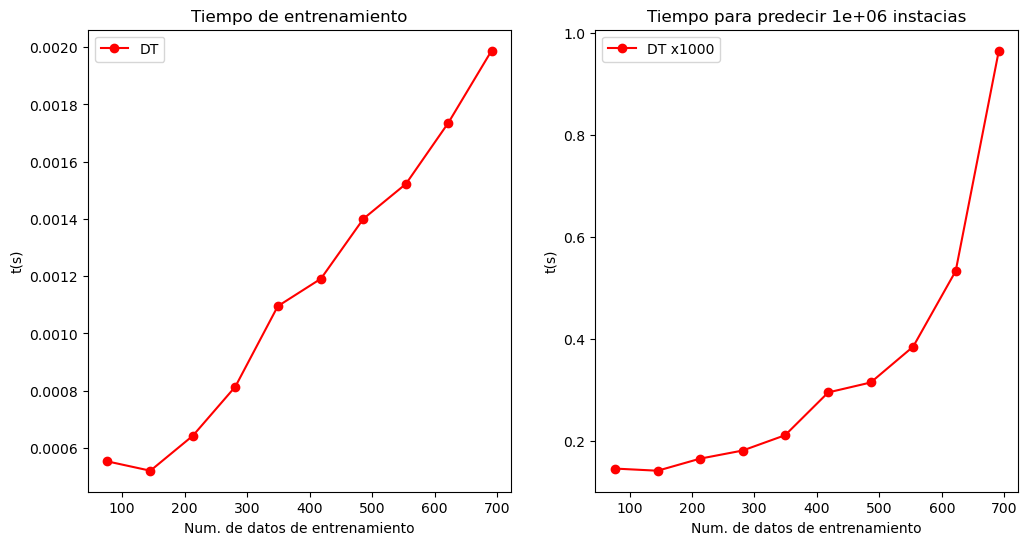

In [27]:
plt.figure(figsize=(12,6))
plt.grid()
plt.subplot(121)
plt.title('Tiempo de entrenamiento')
plt.xlabel("Num. de datos de entrenamiento")
plt.ylabel("t(s)")
plt.plot(sizes, times_tr, 'o-', color="r", label="DT")
plt.legend()
plt.subplot(122)
plt.title('Tiempo para predecir %g instacias' %(factor))
plt.xlabel("Num. de datos de entrenamiento")
plt.ylabel("t(s)")
plt.plot(sizes, times_ts, 'o-', color="r", label="DT x1000")
plt.legend()

<div style="background-color:#AAEEAA;padding:20px;border:solid;">Usando la tabla y la gráfica (si la has hecho) comenta los resultados.<br/>

<ul>
<li>(10) ¿Cómo varían los tiempos de entrenamiento al doblar el número de datos de entrenamiento? ¿Y los tiempos de clasificación?</li>
<li>(11): Explica los resultados</li>
</ul>
</div>
<br/>
<div style="background-color:#EEEEAA;padding:20px;border:solid;">Respuesta:

**Árboles de Decisión:** Son modelos relativamente simples, lo que los hace computacionalmente eficientes para entrenar.

**SVC:** emplea un enfoque más complejo que involucra encontrar un hiperplano óptimo en un espacio potencialmente de alta dimensión. Este proceso de optimización puede requerir una gran cantidad de recursos computacionales, especialmente para conjuntos de datos grandes.

**Árboles de Decisión:** El entrenamiento de árboles de decisión implica encontrar la mejor división en cada nodo en función de una medida de impureza elegida (por ejemplo, impureza de Gini). Esto implica iterar a través de las características y calcular la reducción de impureza para posibles divisiones.

**SVC:** SVC utiliza un algoritmo de optimización para encontrar el hiperplano de margen máximo.

**Árboles de Decisión:** Los árboles de decisión operan directamente en el espacio de características original. No hay necesidad de transformaciones complejas.

**SVC:** En algunos casos, SVC puede usar una función de núcleo para mapear los datos a un espacio de mayor dimensión para una mejor separabilidad.

<ul>
<li>(10): 

**Tiempo de Entrenamiento:**

**SVC:** El tiempo de entrenamiento aumenta linealmente con el número de ejemplos de entrenamiento. Para 300 ejemplos, tarda 6.91 segundos y para 600 ejemplos, tarda 19.24 segundos.

**DT:** El tiempo de entrenamiento es significativamente más rápido para DT en comparación con SVC. Para 300 ejemplos, tarda 0.0012 segundos y para 600 ejemplos, tarda 0.0019 segundos.

**Tiempo de Clasificación:**

**SVC:** El tiempo de clasificación para SVC aumenta linealmente con el número de ejemplos. Para 1 millón de ejemplos, tarda alrededor de 2.58 segundos para 300 ejemplos de entrenamiento y 5.018 segundos para 600 ejemplos de entrenamiento.

**DT:** El tiempo de clasificación para DT también es más rápido que SVC, pero la diferencia es menos notable. Para 1 millón de ejemplos, tarda alrededor de 0.17 segundos para 300 ejemplos de entrenamiento y 0.43 segundos para 600 ejemplos de entrenamiento.


</li>

<li>(11): 

**Tiempo de Entrenamiento:**

**SVC:** El tiempo de entrenamiento de SVC aumenta significativamente con el número de ejemplos de entrenamiento (relación lineal). Esto se debe al complejo proceso de optimización necesario para encontrar el hiperplano óptimo.

**Árboles de Decisión:** El tiempo de entrenamiento de los árboles de decisión es mucho más rápido y casi insignificante en comparación con SVC, incluso con un conjunto de entrenamiento más grande. Esto se debe a que los árboles de decisión construyen una estructura más simple basada en la selección de divisiones por aproximación.

**Tiempo de Clasificación:**

**SVC:** Sorprendentemente, el tiempo de clasificación de SVC es más rápido que el tiempo de entrenamiento, incluso para una gran cantidad de ejemplos. Esto se debe a que la predicción de SVC solo implica evaluar la distancia de los nuevos puntos de datos a los vectores de soporte y el hiperplano, lo cual es computacionalmente eficiente.

**Árboles de Decisión:** El tiempo de clasificación de los árboles de decisión también es relativamente rápido, especialmente para conjuntos de entrenamiento más pequeños. Esto se debe a que la predicción del árbol de decisión implica atravesar la estructura del árbol en base a los valores de las características, lo cual es un proceso sencillo.

La estructura de modelo más simple, la búsqueda eficiente de divisiones y la ausencia de un proceso de optimización complejo contribuyen a la mayor velocidad de entrenamiento del clasificador DecisionTreeClassifier en comparación con SVC.

</li>
</ul></div>